<a href="https://colab.research.google.com/github/Communist02/BIN-22-1_Mazur_Denis_AI/blob/main/z7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# МЛ практика 7. Финализация умений

## **Цель занятия:**
Изучить задачу снижения размерности, познакомиться с более продвинутыми метриками качества, изучение объекта Pipeline из scikit-learn, поиск лучших метрик.

## **Задание состоит из следующих частей:**
1. Объект Pipeline
2. Метрики качества для решения задач классификации, регрессии
3. Снижение размерности
4. Поиск лучших метрик качества (GridSearch)


## Домашка ⏰

1. Заюзать пайплайны для своиз данных
2. Сделать 2D, 3D PCA (T-SNE). Визуалзиация + классификация/регрессия
3. Найти лучшую модель через GridSearch (задача на выбор или обе)
4. Сделать оценку с новыми метриками

Для 👽
1. Использовать Catboost для классификации и регресси (https://catboost.ai/)
2. Вместо T-SNE использовать UMAP (https://umap-learn.readthedocs.io/en/latest/).
3. Найти датасет с картинками и попробовать классфицировать его (в идеале должны быть картинки и файлик с классами). Если не найдете, то можно сделать кластеризацию и предсказывать кластеры
4. Объяснитьк как работает Catboost

In [1]:
!pip install pandas scikit-learn seaborn scipy

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Загрузка набора данных
df = pd.read_csv('diamond.csv')

In [3]:
df

,Carat Weight,Cut,Color,Clarity,Polish,Symmetry,Report,Price
0,1.10,Ideal,H,SI1,VG,EX,GIA,5169
1,0.83,Ideal,H,VS1,ID,ID,AGSL,3470
2,0.85,Ideal,H,SI1,EX,EX,GIA,3183
3,0.91,Ideal,E,SI1,VG,VG,GIA,4370
4,0.83,Ideal,G,SI1,EX,EX,GIA,3171
...,...,...,...,...,...,...,...,...
5995,1.03,Ideal,D,SI1,EX,EX,GIA,6250
5996,1.00,Very Good,D,SI1,VG,VG,GIA,5328
5997,1.02,Ideal,D,SI1,EX,EX,GIA,6157
5998,1.27,Signature-Ideal,G,VS1,EX,EX,GIA,11206


In [4]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df['Cut'] = encoder.fit_transform(df['Cut'])
df['Cut'] = df['Cut'].astype('int64')

In [5]:
is_overprice = np.zeros(len(df['Price']), dtype=np.uint8)
for i in range(len(is_overprice)):
    if df['Price'][i] < 5000:
      is_overprice[i] = 1
    elif df['Price'][i] < 10000:
      is_overprice[i] = 2
    elif df['Price'][i] < 20000:
      is_overprice[i] = 3
    elif df['Price'][i] < 30000:
      is_overprice[i] = 4
    else:
      is_overprice[i] = 5

df['is_overprice'] = is_overprice

df.is_overprice = df.is_overprice.astype('category')
df.Color = df.Color.astype('category')
df.Clarity = df.Clarity.astype('category')
df.Polish = df.Polish.astype('category')
df.Symmetry = df.Symmetry.astype('category')
df.Report = df.Report.astype('category')

y_regression = df['Price'] # числая переменная как y
X_regression = df.copy().drop('Price', axis=1) # переменные для проверки влияния

y_classification = df['is_overprice'] # категориальная переменная как y
X_classification = df.copy().drop('is_overprice', axis=1) # переменные для проверки влияния
X_classification = X_classification.copy().drop('Price', axis=1) # переменные для проверки влияния

In [6]:
df

,Carat Weight,Cut,Color,Clarity,Polish,Symmetry,Report,Price,is_overprice
0,1.10,2,H,SI1,VG,EX,GIA,5169,2
1,0.83,2,H,VS1,ID,ID,AGSL,3470,1
2,0.85,2,H,SI1,EX,EX,GIA,3183,1
3,0.91,2,E,SI1,VG,VG,GIA,4370,1
4,0.83,2,G,SI1,EX,EX,GIA,3171,1
...,...,...,...,...,...,...,...,...,...
5995,1.03,2,D,SI1,EX,EX,GIA,6250,2
5996,1.00,4,D,SI1,VG,VG,GIA,5328,2
5997,1.02,2,D,SI1,EX,EX,GIA,6157,2
5998,1.27,3,G,VS1,EX,EX,GIA,11206,3


In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [8]:
# Выделение числовых и категориальных колонок
numerical_features_regression = X_regression.select_dtypes(include=['float64', 'int64']).columns
categorical_features_regression = X_regression.select_dtypes(include=['category']).columns

numerical_features_classification = X_classification.select_dtypes(include=['float64', 'int64']).columns
categorical_features_classification = X_classification.select_dtypes(include=['category']).columns

# Создание трансформеров
preprocessor_regression = ColumnTransformer(
  [
    ('num', StandardScaler(), numerical_features_regression),
    ('cat', OneHotEncoder(), categorical_features_regression),
  ],
  verbose=True
)

preprocessor_classification = ColumnTransformer(
  [
    ('num', StandardScaler(), numerical_features_classification),
    ('cat', OneHotEncoder(), categorical_features_classification)
  ],
  verbose=True
)

## Регрессия

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np

# Разделение данных
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_regression, y_regression, test_size=0.2, random_state=42
)

# Пайплайн для регрессии
regression_pipeline = Pipeline([
    ('preprocessor', preprocessor_regression),  # Включает StandardScaler и OneHotEncoder
    ('regressor', LinearRegression())          # Модель
], verbose=True)

# Обучение модели
regression_pipeline.fit(X_train_reg, y_train_reg)

# Предсказания
y_pred_reg = regression_pipeline.predict(X_test_reg)

# Метрики для регрессии
mse = mean_squared_error(y_test_reg, y_pred_reg)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test_reg, y_pred_reg)

print(f"\nСреднеквадратичная ошибка (MSE): {mse:.4f}")
print(f"Корень из MSE (RMSE): {rmse:.4f}")
print(f"Средний абсолютный процент ошибки (MAPE): {mape:.4f}, то есть {mape * 100:.4f}%")


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   0.0s

Среднеквадратичная ошибка (MSE): 8989376.1142
Корень из MSE (RMSE): 2998.2288
Средний абсолютный процент ошибки (MAPE): 0.1367, то есть 13.6679%


# Классификация

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss

# Разделение данных
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_classification, y_classification, test_size=0.2, random_state=42
)

# Пайплайн для классификации
classification_pipeline = Pipeline([
    ('preprocessor', preprocessor_classification),  # Включает StandardScaler и OneHotEncoder
    ('classifier', DecisionTreeClassifier(random_state=42))
], verbose=True)

# Обучение модели
classification_pipeline.fit(X_train_clf, y_train_clf)

# Предсказания
y_pred_clf = classification_pipeline.predict(X_test_clf)
y_pred_proba_clf = classification_pipeline.predict_proba(X_test_clf)

# Метрики для классификации
accuracy = accuracy_score(y_test_clf, y_pred_clf)
precision = precision_score(y_test_clf, y_pred_clf, average='weighted')
recall = recall_score(y_test_clf, y_pred_clf, average='weighted')
f1 = f1_score(y_test_clf, y_pred_clf, average='weighted')
auc = roc_auc_score(y_test_clf, y_pred_proba_clf, multi_class='ovr', average='weighted')
logloss = log_loss(y_test_clf, y_pred_proba_clf)

print(f"Точность (accuracy): {accuracy:.4f}")
print(f"Точность (precision): {precision:.4f}")
print(f"Полнота (recall): {recall:.4f}")
print(f"F1-мера: {f1:.4f}")
print(f"AUC: {auc:.4f}")
print(f"Логарифмическая потеря (log-loss): {logloss:.4f}")

[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.1s
Точность (accuracy): 0.8717
Точность (precision): 0.8729
Полнота (recall): 0.8717
F1-мера: 0.8717
AUC: 0.9167
Логарифмическая потеря (log-loss): 4.3655


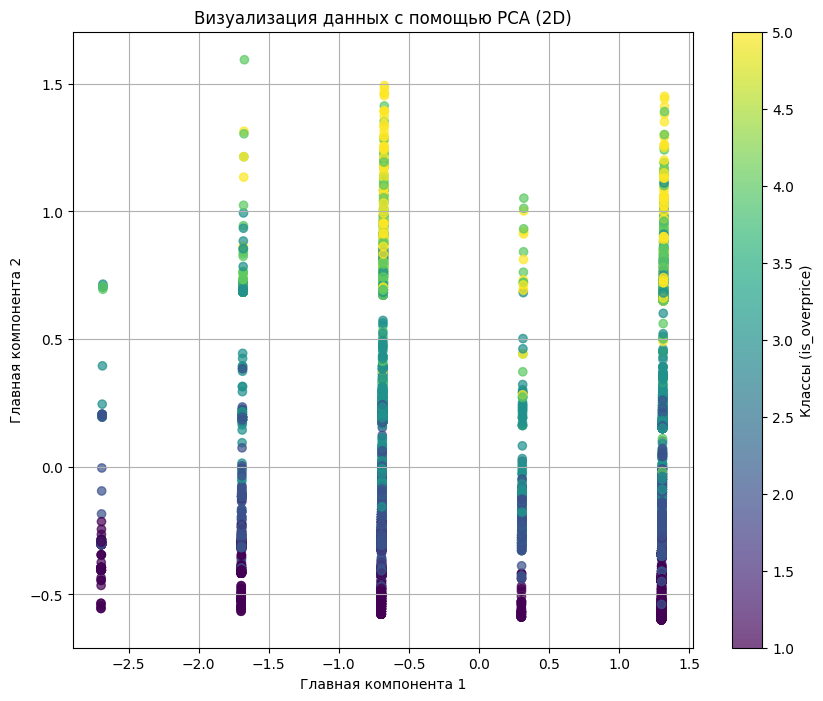

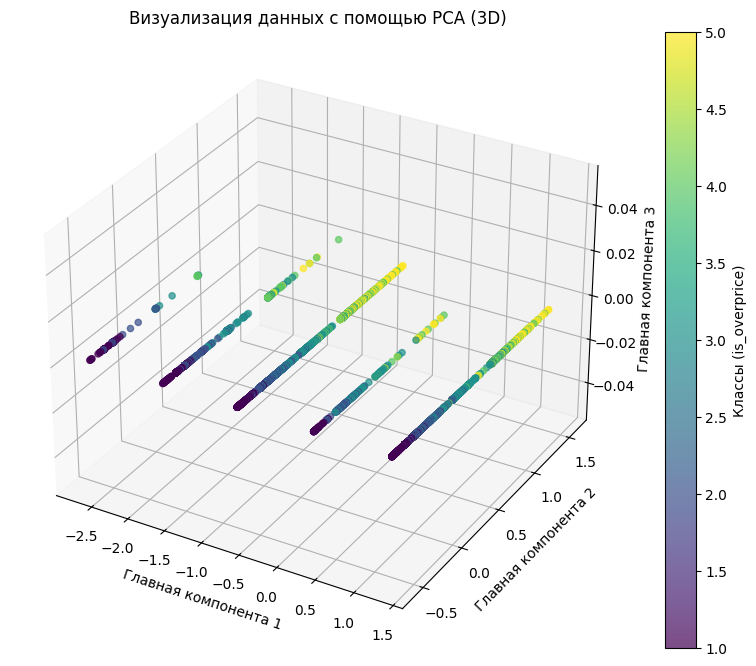

Точность классификации с PCA (2D): 0.7192
Точность классификации с PCA (3D): 0.7192


In [11]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from mpl_toolkits.mplot3d import Axes3D

# Преобразование данных с помощью PCA
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_classification.select_dtypes(include=['float64', 'int64']))

pca_3d = PCA(n_components=2)
X_pca_3d = pca_3d.fit_transform(X_classification.select_dtypes(include=['float64', 'int64']))

# 2D визуализация PCA
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=y_classification, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Классы (is_overprice)')
plt.title("Визуализация данных с помощью PCA (2D)")
plt.xlabel("Главная компонента 1")
plt.ylabel("Главная компонента 2")
plt.grid(True)
plt.show()

# 3D визуализация PCA
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], c=y_classification, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Классы (is_overprice)')
ax.set_title("Визуализация данных с помощью PCA (3D)")
ax.set_xlabel("Главная компонента 1")
ax.set_ylabel("Главная компонента 2")
ax.set_zlabel("Главная компонента 3")
plt.show()

# Классификация PCA (2D и 3D)
# Разделение данных
X_train_2d, X_test_2d, y_train, y_test = train_test_split(X_pca_2d, y_classification, test_size=0.2, random_state=42)
X_train_3d, X_test_3d = train_test_split(X_pca_3d, test_size=0.2, random_state=42)

# Модель
clf = RandomForestClassifier(random_state=42)

# Обучение на 2D данных
clf.fit(X_train_2d, y_train)
y_pred_2d = clf.predict(X_test_2d)
accuracy_2d = accuracy_score(y_test, y_pred_2d)
print(f"Точность классификации с PCA (2D): {accuracy_2d:.4f}")

# Обучение на 3D данных
clf.fit(X_train_3d, y_train)
y_pred_3d = clf.predict(X_test_3d)
accuracy_3d = accuracy_score(y_test, y_pred_3d)
print(f"Точность классификации с PCA (3D): {accuracy_3d:.4f}")

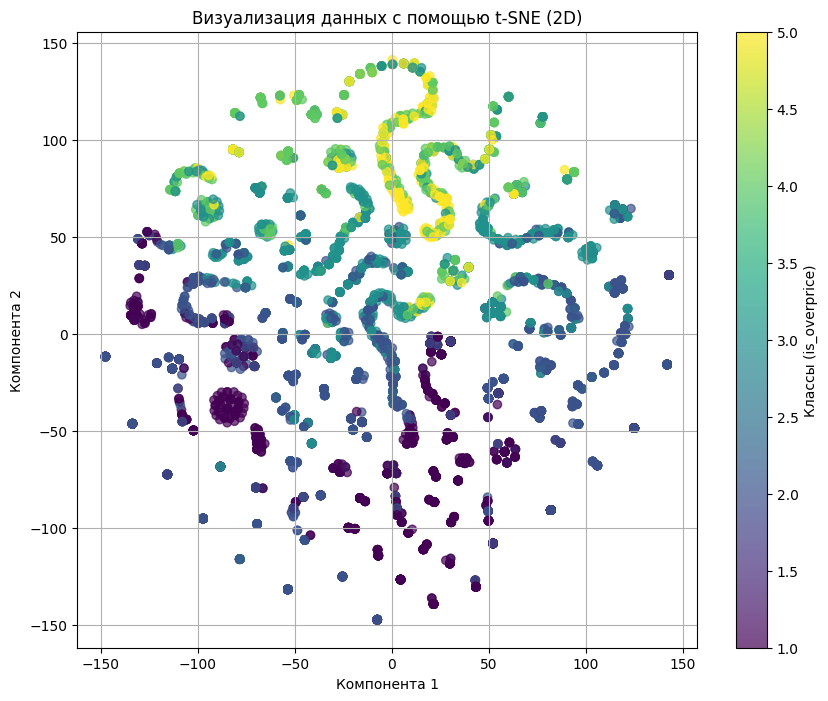

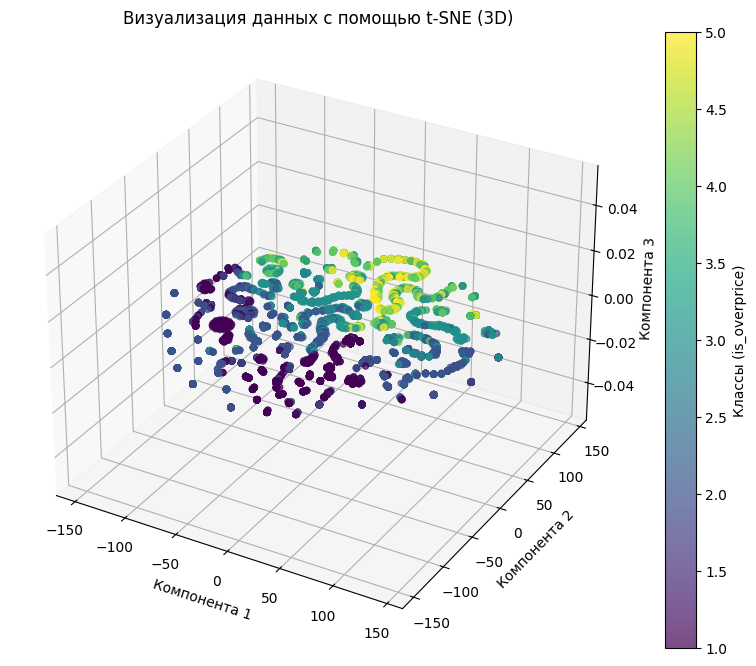

NameError: name 'RandomForestClassifier' is not defined

In [ ]:
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier

# Преобразование данных с помощью t-SNE
tsne_2d = TSNE(n_components=2, random_state=42)
X_tsne_2d = tsne_2d.fit_transform(X_classification.select_dtypes(include=['float64', 'int64']))

tsne_3d = TSNE(n_components=2, random_state=42)
X_tsne_3d = tsne_3d.fit_transform(X_classification.select_dtypes(include=['float64', 'int64']))

# 2D визуализация t-SNE
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_tsne_2d[:, 0], X_tsne_2d[:, 1], c=y_classification, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Классы (is_overprice)')
plt.title("Визуализация данных с помощью t-SNE (2D)")
plt.xlabel("Компонента 1")
plt.ylabel("Компонента 2")
plt.grid(True)
plt.show()

# 3D визуализация t-SNE
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_tsne_3d[:, 0], X_tsne_3d[:, 1], c=y_classification, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Классы (is_overprice)')
ax.set_title("Визуализация данных с помощью t-SNE (3D)")
ax.set_xlabel("Компонента 1")
ax.set_ylabel("Компонента 2")
ax.set_zlabel("Компонента 3")
plt.show()

# Классификация t-SNE (2D и 3D)
# Разделение данных
X_train_2d, X_test_2d, y_train, y_test = train_test_split(X_tsne_2d, y_classification, test_size=0.2, random_state=42)
X_train_3d, X_test_3d = train_test_split(X_tsne_3d, test_size=0.2, random_state=42)

# Модель
clf = RandomForestClassifier(random_state=42)

# Обучение на 2D данных
clf.fit(X_train_2d, y_train)
y_pred_2d = clf.predict(X_test_2d)
accuracy_2d = accuracy_score(y_test, y_pred_2d)
print(f"Точность классификации с t-SNE (2D): {accuracy_2d:.4f}")

# Обучение на 3D данных
clf.fit(X_train_3d, y_train)
y_pred_3d = clf.predict(X_test_3d)
accuracy_3d = accuracy_score(y_test, y_pred_3d)
print(f"Точность классификации с t-SNE (3D): {accuracy_3d:.4f}")

In [ ]:
!pip install umap-learn

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


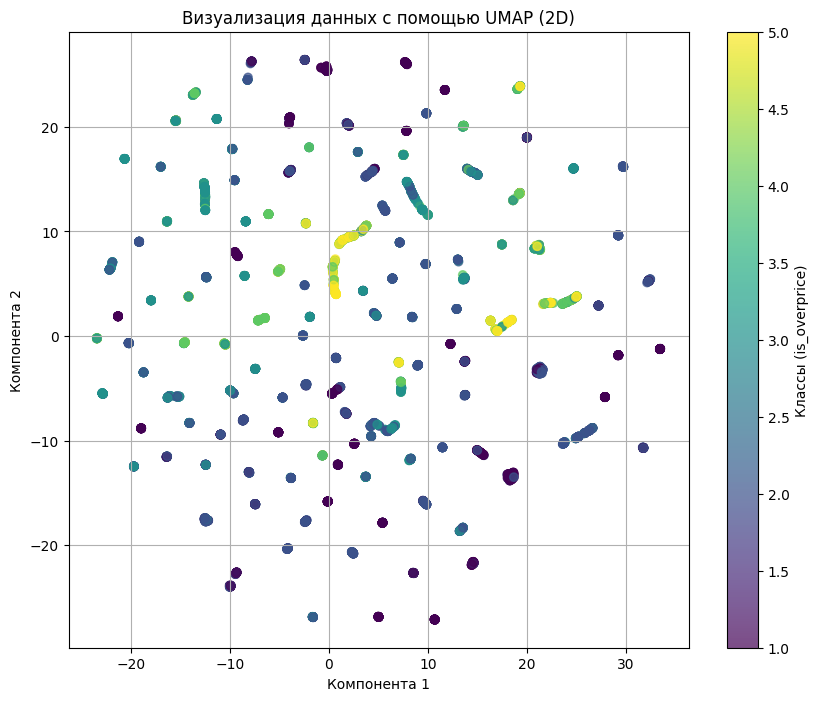

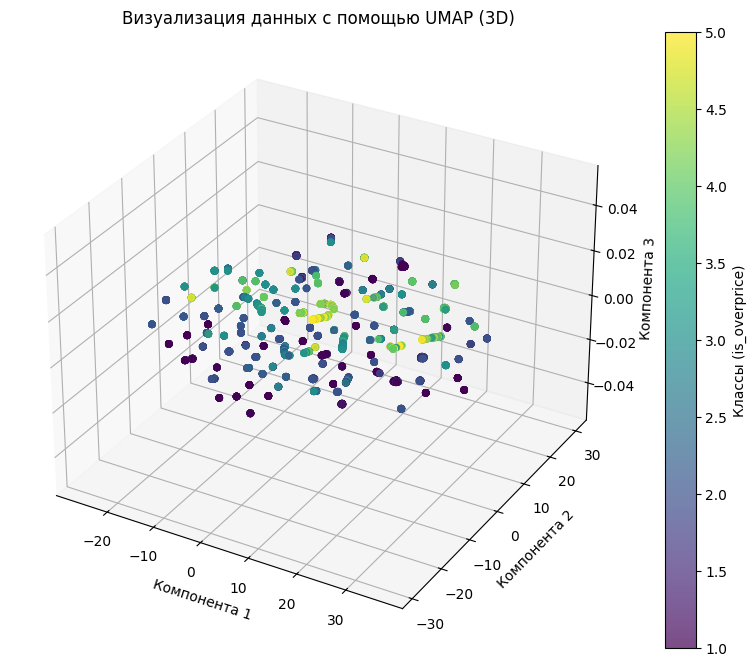

Точность классификации с UMAP (2D): 0.6842
Точность классификации с UMAP (3D): 0.6658


In [ ]:
import umap
from sklearn.ensemble import RandomForestClassifier

# Преобразование данных с помощью t-SNE
umap_2d = umap.UMAP(n_components=2, random_state=42)
X_umap_2d = umap_2d.fit_transform(X_classification.select_dtypes(include=['float64', 'int64']))

umap_3d = umap.UMAP(n_components=2, random_state=42)
X_umap_3d = umap_3d.fit_transform(X_classification.select_dtypes(include=['float64', 'int64']))

# 2D визуализация UMAP
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_umap_2d[:, 0], X_umap_2d[:, 1], c=y_classification, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Классы (is_overprice)')
plt.title("Визуализация данных с помощью UMAP (2D)")
plt.xlabel("Компонента 1")
plt.ylabel("Компонента 2")
plt.grid(True)
plt.show()

# 3D визуализация UMAP
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_umap_3d[:, 0], X_umap_3d[:, 1], c=y_classification, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Классы (is_overprice)')
ax.set_title("Визуализация данных с помощью UMAP (3D)")
ax.set_xlabel("Компонента 1")
ax.set_ylabel("Компонента 2")
ax.set_zlabel("Компонента 3")
plt.show()

# Классификация UMAP (2D и 3D)
# Разделение данных
X_train_2d, X_test_2d, y_train, y_test = train_test_split(X_umap_2d, y_classification, test_size=0.2, random_state=42)
X_train_3d, X_test_3d = train_test_split(X_umap_3d, test_size=0.2, random_state=42)

# Модель
clf = RandomForestClassifier(random_state=42)

# Обучение на 2D данных
clf.fit(X_train_2d, y_train)
y_pred_2d = clf.predict(X_test_2d)
accuracy_2d = accuracy_score(y_test, y_pred_2d)
print(f"Точность классификации с UMAP (2D): {accuracy_2d:.4f}")

# Обучение на 3D данных
clf.fit(X_train_3d, y_train)
y_pred_3d = clf.predict(X_test_3d)
accuracy_3d = accuracy_score(y_test, y_pred_3d)
print(f"Точность классификации с UMAP (3D): {accuracy_3d:.4f}")

In [12]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
import numpy as np

# Определение параметров для поиска
param_grid_regression = {
    'regressor__alpha': [0.1, 1.0, 10.0]  # Параметры регуляризации для Ridge
}

param_random_regression = {
    'regressor__alpha': np.linspace(0.1, 10, 100)  # Диапазон для случайного поиска
}

# Пайплайн для регрессии
regression_pipeline = Pipeline([
    ('preprocessor', preprocessor_regression),
    ('regressor', Ridge())
], verbose=True)

# GridSearchCV для регрессии
grid_search_reg = GridSearchCV(regression_pipeline, param_grid=param_grid_regression, cv=5, scoring='neg_mean_squared_error', verbose=1)
grid_search_reg.fit(X_train_reg, y_train_reg)
print("\nЛучшие параметры (GridSearch) для регрессии:", grid_search_reg.best_params_)
print("Лучший MSE (GridSearch):", -grid_search_reg.best_score_)

# RandomizedSearchCV для регрессии
random_search_reg = RandomizedSearchCV(regression_pipeline, param_distributions=param_random_regression, n_iter=10, cv=5, scoring='neg_mean_squared_error', verbose=1, random_state=42)
random_search_reg.fit(X_train_reg, y_train_reg)
print("\nЛучшие параметры (RandomSearch) для регрессии:", random_search_reg.best_params_)
print("Лучший MSE (RandomSearch):", -random_search_reg.best_score_)
print("Лучший RMSE (RandomSearch):", (-random_search_reg.best_score_) ** 0.5)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.1s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.2s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   0.1s
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.1s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.2s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   0.1s
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.1s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.1s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   0.1s
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransforme

# Доп для наказанных

In [13]:
!pip install catboost ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


# Классификация

In [14]:
X_classification = X_classification.copy().drop('Color', axis=1)
X_classification = X_classification.copy().drop('Clarity', axis=1)
X_classification = X_classification.copy().drop('Polish', axis=1)
X_classification = X_classification.copy().drop('Symmetry', axis=1)
X_classification = X_classification.copy().drop('Report', axis=1)

In [15]:
df.is_overprice = df.is_overprice.astype('int64')

In [27]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_iris

# Разделение на обучающую и тестовую выборки
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_classification, y_classification, test_size=0.2, random_state=42)

# Обучение модели классификации
model = CatBoostClassifier(iterations=10, learning_rate=0.1, depth=6, verbose=0)
model.fit(X_train_clf, y_train_clf)

# Предсказания
y_pred_clf = model.predict(X_test_clf)
y_pred_proba_clf = model.predict_proba(X_test_clf)

# Метрики для классификации
accuracy = accuracy_score(y_test_clf, y_pred_clf)
precision = precision_score(y_test_clf, y_pred_clf, average='weighted')
recall = recall_score(y_test_clf, y_pred_clf, average='weighted')
f1 = f1_score(y_test_clf, y_pred_clf, average='weighted')
auc = roc_auc_score(y_test_clf, y_pred_proba_clf, multi_class='ovr', average='weighted')
logloss = log_loss(y_test_clf, y_pred_proba_clf)

# Оценка модели
print(f"Точность (accuracy): {accuracy:.4f}")
print(f"Точность (precision): {precision:.4f}")
print(f"Полнота (recall): {recall:.4f}")
print(f"F1-мера: {f1:.4f}")
print(f"AUC: {auc:.4f}")
print(f"Логарифмическая потеря (log-loss): {logloss:.4f}")

Точность (accuracy): 0.7267
Точность (precision): 0.7318
Полнота (recall): 0.7267
F1-мера: 0.7225
AUC: 0.9152
Логарифмическая потеря (log-loss): 0.8726


In [19]:
X_regression = X_regression.copy().drop('Color', axis=1).reindex()
X_regression = X_regression.copy().drop('Clarity', axis=1).reindex()
X_regression = X_regression.copy().drop('Polish', axis=1).reindex()
X_regression = X_regression.copy().drop('Symmetry', axis=1).reindex()
X_regression = X_regression.copy().drop('Report', axis=1).reindex()
X_regression = X_regression.copy().drop('is_overprice', axis=1).reindex()

Регрессия

In [20]:
from catboost import CatBoostRegressor
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_squared_error

# Разделение данных
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_regression, y_regression, test_size=0.2, random_state=42
)

# Обучение модели регрессии
model = CatBoostRegressor(iterations=50, learning_rate=0.1, depth=10, verbose=0)
model.fit(X_train_reg, y_train_reg)

# Оценка модели
y_pred_reg = model.predict(X_test_reg)

mse = mean_squared_error(y_test_reg, y_pred_reg)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test_reg, y_pred_reg)

print(f"\nСреднеквадратичная ошибка (MSE): {mse:.4f}")
print(f"Корень из MSE (RMSE): {rmse:.4f}")
print(f"Средний абсолютный процент ошибки (MAPE): {mape:.4f}, то есть {mape * 100:.4f}%")


Среднеквадратичная ошибка (MSE): 26659474.9765
Корень из MSE (RMSE): 5163.2814
Средний абсолютный процент ошибки (MAPE): 0.2036, то есть 20.3649%


# Для картинок

In [16]:
!pip install tensorflow-datasets

In [34]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_iris

import tensorflow_datasets as tfds

import numpy as np


ds = tfds.load('mnist', split='train', as_supervised=True)  # `as_supervised` дает (image, label)

# Преобразование в numpy массивы
X, y = [], []

for image, label in tfds.as_numpy(ds):
    X.append(image)
    y.append(label)

# Преобразование списков в numpy массивы
X = np.stack(X)  # Создает массив из списка изображений
y = np.array(y)  # Создает массив меток

# Разделение на обучающую и тестовую выборки
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X, y, test_size=0.2, random_state=42)

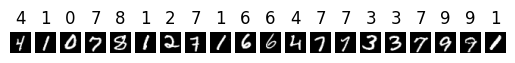

In [46]:
import matplotlib.pyplot as plt

for i in range(20):
    plt.subplot(1, 20, i + 1)
    plt.imshow(X[i].squeeze(), cmap='gray')
    plt.title(f"{y[i]}")
    plt.axis('off')
plt.show()

In [47]:
X_train_clf = X_train_clf.reshape(X_train_clf.shape[0], -1)
X_test_clf = X_test_clf.reshape(X_test_clf.shape[0], -1)

# Обучение модели классификации
model = CatBoostClassifier(iterations=10, learning_rate=0.1, depth=6, verbose=0)
model.fit(X_train_clf, y_train_clf)

# Предсказания
y_pred_clf = model.predict(X_test_clf)
y_pred_proba_clf = model.predict_proba(X_test_clf)

# Метрики для классификации
accuracy = accuracy_score(y_test_clf, y_pred_clf)
precision = precision_score(y_test_clf, y_pred_clf, average='weighted')
recall = recall_score(y_test_clf, y_pred_clf, average='weighted')
f1 = f1_score(y_test_clf, y_pred_clf, average='weighted')
auc = roc_auc_score(y_test_clf, y_pred_proba_clf, multi_class='ovr', average='weighted')
logloss = log_loss(y_test_clf, y_pred_proba_clf)

# Оценка модели
print(f"Точность (accuracy): {accuracy:.4f}")
print(f"Точность (precision): {precision:.4f}")
print(f"Полнота (recall): {recall:.4f}")
print(f"F1-мера: {f1:.4f}")
print(f"AUC: {auc:.4f}")
print(f"Логарифмическая потеря (log-loss): {logloss:.4f}")

Точность (accuracy): 0.8173
Точность (precision): 0.8176
Полнота (recall): 0.8173
F1-мера: 0.8160
AUC: 0.9781
Логарифмическая потеря (log-loss): 1.0601


/

/

/

/

/

/

/

/

/

/

/

/

/

In [ ]:
!pip install pandas scikit-learn seaborn scipy

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Загрузка набора данных
df = pd.read_csv('diamond.csv')

In [ ]:
df

,Carat Weight,Cut,Color,Clarity,Polish,Symmetry,Report,Price
0,1.10,Ideal,H,SI1,VG,EX,GIA,5169
1,0.83,Ideal,H,VS1,ID,ID,AGSL,3470
2,0.85,Ideal,H,SI1,EX,EX,GIA,3183
3,0.91,Ideal,E,SI1,VG,VG,GIA,4370
4,0.83,Ideal,G,SI1,EX,EX,GIA,3171
...,...,...,...,...,...,...,...,...
5995,1.03,Ideal,D,SI1,EX,EX,GIA,6250
5996,1.00,Very Good,D,SI1,VG,VG,GIA,5328
5997,1.02,Ideal,D,SI1,EX,EX,GIA,6157
5998,1.27,Signature-Ideal,G,VS1,EX,EX,GIA,11206


In [ ]:
is_overprice = np.zeros(len(df['Price']), dtype=np.uint8)
for i in range(len(is_overprice)):
    if df['Price'][i] < 5000:
      is_overprice[i] = 1
    elif df['Price'][i] < 10000:
      is_overprice[i] = 2
    elif df['Price'][i] < 20000:
      is_overprice[i] = 3
    elif df['Price'][i] < 30000:
      is_overprice[i] = 4
    else:
      is_overprice[i] = 5

df['is_overprice'] = is_overprice

df.is_overprice = df.is_overprice.astype('category')
df.Color = df.Color.astype('category')
df.Clarity = df.Clarity.astype('category')
df.Polish = df.Polish.astype('category')
df.Symmetry = df.Symmetry.astype('category')
df.Report = df.Report.astype('category')
df.Cut = df.Report.astype('category')

y_regression = df['Price'] # числая переменная как y
X_regression = df.copy().drop('Price', axis=1).reindex() # переменные для проверки влияния

y_classification = df['is_overprice'] # категориальная переменная как y
X_classification = df.copy().drop('is_overprice', axis=1).reindex() # переменные для проверки влияния
# X_classification = X_classification.copy().drop('Price', axis=1).reindex() # переменные для проверки влияния

In [ ]:
X_regression.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Carat Weight  6000 non-null   float64 
 1   Cut           6000 non-null   category
 2   Color         6000 non-null   category
 3   Clarity       6000 non-null   category
 4   Polish        6000 non-null   category
 5   Symmetry      6000 non-null   category
 6   Report        6000 non-null   category
 7   is_overprice  6000 non-null   category
dtypes: category(7), float64(1)
memory usage: 89.3 KB


## Pipeline

#### **Что такое ColumnTransformer?**
**ColumnTransformer** — это объект в `scikit-learn`, который позволяет применять разные трансформации к разным группам признаков (столбцов) в одном шаге.

- **Пример кода:**
  ```python
  from sklearn.compose import ColumnTransformer
  from sklearn.preprocessing import StandardScaler, OneHotEncoder

  preprocessor = ColumnTransformer([
      ('num', StandardScaler(), numeric_columns),
      ('cat', OneHotEncoder(), categorical_columns)
  ])


#### **Что такое Pipeline?**
**Pipeline** — это объект в `scikit-learn`, который объединяет последовательность шагов обработки данных и обучения модели в единый процесс. Каждый шаг выполняется последовательно, начиная с предобработки данных и заканчивая обучением модели.

1. Каждый шаг состоит из имени и объекта (`'step_name', transformer_or_model`).
2. Все шаги, кроме последнего, должны быть трансформаторами (иметь методы `fit` и `transform`).
3. Последний шаг — это модель с методами `fit` и `predict`.

---

### **Пример использования Pipeline**

```python
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

# Создание пайплайна
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Масштабирование данных
    ('classifier', RandomForestClassifier(random_state=42))  # Обучение модели
])

# Обучение модели
pipeline.fit(X_train, y_train)

# Предсказания
y_pred = pipeline.predict(X_test)


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [ ]:
# Выделение числовых и категориальных колонок
numerical_features_regression = X_regression.select_dtypes(include=['float64', 'int64']).columns
categorical_features_regression = X_regression.select_dtypes(include=['category']).columns

numerical_features_classification = X_classification.select_dtypes(include=['float64', 'int64']).columns
categorical_features_classification = X_classification.select_dtypes(include=['category']).columns

# Создание трансформеров
preprocessor_regression = ColumnTransformer(
  [
    ('num', StandardScaler(), numerical_features_regression),
    ('cat', OneHotEncoder(), categorical_features_regression),
  ],
  verbose=True
)

preprocessor_classification = ColumnTransformer(
  [
    ('num', StandardScaler(), numerical_features_classification),
    ('cat', OneHotEncoder(), categorical_features_classification)
  ],
  verbose=True
)

### Для регрессии

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np

# Разделение данных
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_regression, y_regression, test_size=0.2, random_state=42
)

# Пайплайн для регрессии
regression_pipeline = Pipeline([
    ('preprocessor', preprocessor_regression),  # Включает StandardScaler и OneHotEncoder
    ('regressor', LinearRegression())          # Модель
], verbose=True)

# Обучение модели
regression_pipeline.fit(X_train_reg, y_train_reg)

# Предсказания
y_pred_reg = regression_pipeline.predict(X_test_reg)

# Метрики для регрессии
mse = mean_squared_error(y_test_reg, y_pred_reg)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test_reg, y_pred_reg)

print(f"\nСреднеквадратичная ошибка (MSE): {mse:.4f}")
print(f"Корень из MSE (RMSE): {rmse:.4f}")
print(f"Средний абсолютный процент ошибки (MAPE): {mape:.4f}, то есть {mape * 100:.4f}%")


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   0.0s

Среднеквадратичная ошибка (MSE): 8997878.8029
Корень из MSE (RMSE): 2999.6464
Средний абсолютный процент ошибки (MAPE): 0.1368, то есть 13.6821%


#### Пару слов о новых метриках

**RMSE: Корень из среднеквадратичной ошибки (Root Mean Squared Error)**

**RMSE** — это метрика, которая измеряет среднее отклонение предсказанных значений от фактических в квадрате, а затем возвращает квадратный корень результата. Это позволяет интерпретировать ошибки в тех же единицах измерения, что и целевая переменная \( y \).

##### **Как работает RMSE?**
1. Вычисляет разницу между предсказанными и фактическими значениями.
2. Возводит каждую разницу в квадрат (чтобы ошибки не сокращались за счет их знака).
3. Находит среднее значение квадратов ошибок.
4. Берет квадратный корень, чтобы вернуть метрику в исходные единицы.

##### **Особенности RMSE:**
- **Чувствительность к большим ошибкам**: RMSE сильнее наказывает крупные отклонения, чем, например, MAE.
- Хорошо подходит для задач, где важны большие ошибки, и нужно их минимизировать.

##### **Пример интерпретации:**
Если RMSE равно 5, это означает, что в среднем предсказания модели отклоняются от фактических значений на **5 единиц**.

---

##### **MAPE: Средний абсолютный процент ошибки (Mean Absolute Percentage Error)**

**MAPE** — это метрика, которая измеряет среднюю ошибку предсказаний в процентах относительно фактических значений. Она показывает, на сколько процентов в среднем модель ошибается в предсказаниях.

##### **Как работает MAPE?**
1. Вычисляет абсолютную разницу между предсказанными и фактическими значениями.
2. Делит каждую ошибку на фактическое значение.
3. Берет среднее значение этих долей и умножает на 100, чтобы выразить в процентах.

##### **Особенности MAPE:**
- Легко интерпретируется: "Наша модель ошибается в среднем на X%".
- Не учитывает направление ошибки (переоценка или недооценка).
- Чувствительна к малым значениям целевой переменной: если истинное значение близко к нулю, MAPE может стать крайне высокой.

##### **Пример интерпретации:**
Если MAPE равно \( 10 \%\), это означает, что модель в среднем ошибается на **10%** от фактического значения.


### Тоже самое для классификации

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss

# Разделение данных
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_classification, y_classification, test_size=0.2, random_state=42
)

# Пайплайн для классификации
classification_pipeline = Pipeline([
    ('preprocessor', preprocessor_classification),  # Включает StandardScaler и OneHotEncoder
    ('classifier', DecisionTreeClassifier(random_state=42))
], verbose=True)

# Обучение модели
classification_pipeline.fit(X_train_clf, y_train_clf)

# Предсказания
y_pred_clf = classification_pipeline.predict(X_test_clf)
y_pred_proba_clf = classification_pipeline.predict_proba(X_test_clf)

# Метрики для классификации
accuracy = accuracy_score(y_test_clf, y_pred_clf)
precision = precision_score(y_test_clf, y_pred_clf, average='weighted')
recall = recall_score(y_test_clf, y_pred_clf, average='weighted')
f1 = f1_score(y_test_clf, y_pred_clf, average='weighted')
auc = roc_auc_score(y_test_clf, y_pred_proba_clf, multi_class='ovr', average='weighted')
logloss = log_loss(y_test_clf, y_pred_proba_clf)

print(f"Точность (accuracy): {accuracy:.4f}")
print(f"Точность (precision): {precision:.4f}")
print(f"Полнота (recall): {recall:.4f}")
print(f"F1-мера: {f1:.4f}")
print(f"AUC: {auc:.4f}")
print(f"Логарифмическая потеря (log-loss): {logloss:.4f}")


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.0s
Точность (accuracy): 0.9992
Точность (precision): 0.9992
Полнота (recall): 0.9992
F1-мера: 0.9992
AUC: 0.9993
Логарифмическая потеря (log-loss): 0.0300


#### Пару слов о новой метрике

Если log-loss равен **14.6115**, это указывает на то, что модель предсказывает вероятности с большими ошибками. Чем выше log-loss, тем хуже модель справляется с прогнозированием вероятностей.

##### **Интерпретация log-loss:**
- **Низкое значение log-loss:** модель хорошо калибрована, предсказанные вероятности близки к истинным значениям (например, высокая вероятность для правильного класса).
- **Высокое значение log-loss (как 14.6115):** вероятности модели не соответствуют истинным классам, либо она делает "уверенные" ошибки, назначая высоким вероятностям неправильные классы.

##### **Что делать при высоком log-loss?**
1. **Улучшить модель:**
   - Использовать более сложные алгоритмы.
   - Настроить гиперпараметры.
2. **Улучшить данные:**
   - Удалить шум.
   - Проверить сбалансированность классов.
3. **Калибровка вероятностей:**
   - Методы вроде Platt Scaling или Isotonic Regression помогают лучше калибровать вероятности.

Log-loss в значении 14.6115 — это знак, что модель требует значительных улучшений.

## Снижение размерности

#### **Что такое снижение размерности?**
Снижение размерности — это процесс преобразования данных с большим количеством признаков (столбцов) в набор меньшего размера, сохраняя при этом как можно больше важной информации. Это особенно полезно, когда данные имеют высокую размерность, что может приводить к:

1. **Избыточной информации:** Некоторые признаки могут быть сильно коррелированы или не нести полезной информации.
2. **Проклятию размерности:** Чем больше признаков, тем сложнее моделям найти закономерности.
3. **Высокой вычислительной сложности:** Больше признаков — больше времени и ресурсов на обработку.

---

#### **Для чего нужно снижение размерности?**
- **Улучшение производительности моделей:** Удаление лишних признаков уменьшает шум и делает данные более управляемыми.
- **Ускорение работы:** Меньшее число признаков ускоряет обучение моделей.
- **Визуализация:** Легче визуализировать данные, если они сокращены до 2D или 3D.
- **Понимание данных:** Снижая размерность, мы можем увидеть основные направления вариации в данных.

---

### **PCA: Главные компоненты (Principal Component Analysis)**

#### **Что это?**
PCA (Анализ главных компонент) — это метод снижения размерности, который ищет новые признаки (главные компоненты), максимизирующие объясненную дисперсию данных. Эти компоненты — это линейные комбинации исходных признаков.

#### **Как работает PCA?**
1. Вычисляет дисперсию данных и находит направления (оси), вдоль которых данные изменяются максимально.
2. Создает новые признаки — главные компоненты.
3. Упорядочивает компоненты по убыванию их важности (объясненной дисперсии).
4. Оставляет только несколько самых важных компонентов.

#### **Когда использовать PCA?**
- Когда нужно сократить количество признаков перед обучением модели.
- Когда признаки сильно коррелированы.
- Для ускорения работы моделей.

---

### **t-SNE: Визуализация соседей (t-distributed Stochastic Neighbor Embedding)**

#### **Что это?**
t-SNE — это метод, предназначенный для визуализации данных. Он переводит высокоразмерные данные в 2D или 3D, сохраняя близость между точками. Это помогает увидеть скрытые структуры в данных.

#### **Как работает t-SNE?**
1. Вычисляет, какие точки в многомерном пространстве являются "соседями".
2. Строит новую, низкоразмерную карту данных, стараясь сохранить те же отношения между точками.

#### **Особенности t-SNE:**
- **Фокус на локальной структуре:** Лучше всего показывает кластеры данных.
- **Визуализация сложных данных:** Например, для наборов с тысячами признаков.

#### **Когда использовать t-SNE?**
- Для визуализации сложных наборов данных (например, изображения, тексты).
- Чтобы понять, как объекты сгруппированы в пространстве.

---

### **Сравнение PCA и t-SNE**
| **Критерий**         | **PCA**                              | **t-SNE**                           |
|-----------------------|---------------------------------------|--------------------------------------|
| **Цель**             | Уменьшение размерности               | Визуализация данных                 |
| **Тип структуры**    | Сохраняет глобальную структуру       | Сохраняет локальную структуру       |
| **Скорость**         | Быстрее                              | Медленнее                           |
| **Применение**       | Для предобработки перед моделированием | Для анализа и визуализации          |

---

### **Итог**
- Используйте **PCA**, если хотите уменьшить размер данных для обучения модели.
- Используйте **t-SNE**, если хотите визуализировать сложные данные и понять их структуру.

### Пример использования

Попробуем визуализировать признаки в 2D и 3D пространстве алгоритмами PCA и T-SNE

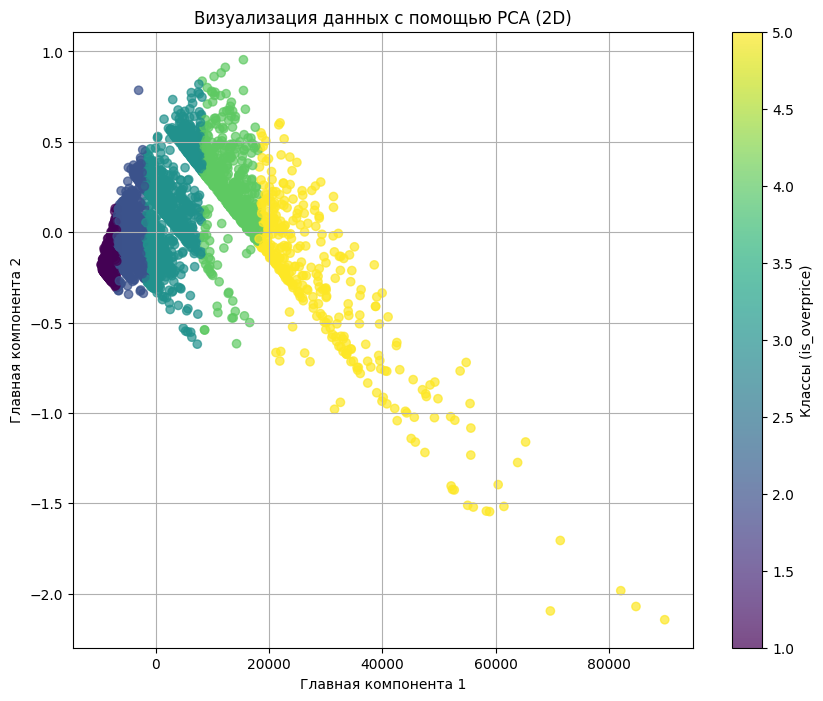

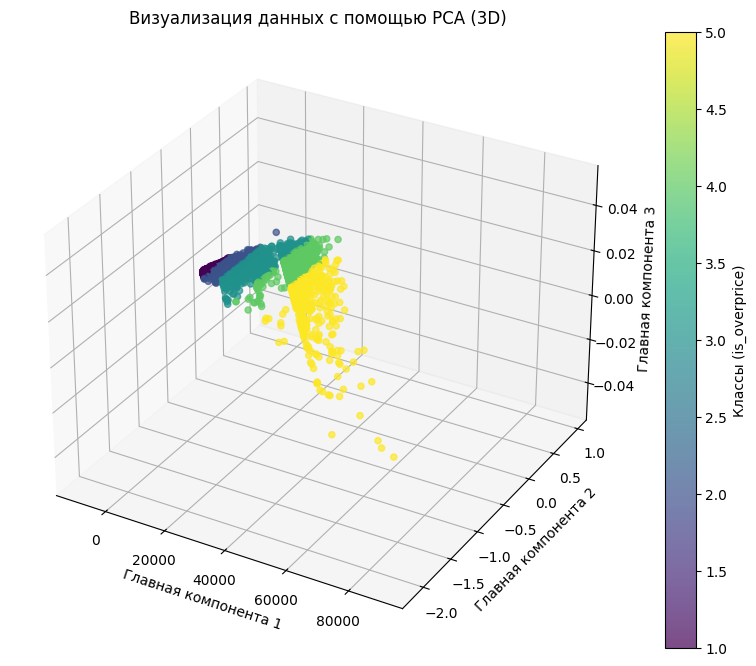

Точность классификации с PCA (2D): 0.9992
Точность классификации с PCA (3D): 0.9992


In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from mpl_toolkits.mplot3d import Axes3D

# Преобразование данных с помощью PCA
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_classification.select_dtypes(include=['float64', 'int64']))

pca_3d = PCA(n_components=2)
X_pca_3d = pca_3d.fit_transform(X_classification.select_dtypes(include=['float64', 'int64']))

# 2D визуализация PCA
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=y_classification, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Классы (is_overprice)')
plt.title("Визуализация данных с помощью PCA (2D)")
plt.xlabel("Главная компонента 1")
plt.ylabel("Главная компонента 2")
plt.grid(True)
plt.show()

# 3D визуализация PCA
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], c=y_classification, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Классы (is_overprice)')
ax.set_title("Визуализация данных с помощью PCA (3D)")
ax.set_xlabel("Главная компонента 1")
ax.set_ylabel("Главная компонента 2")
ax.set_zlabel("Главная компонента 3")
plt.show()

# Классификация PCA (2D и 3D)
# Разделение данных
X_train_2d, X_test_2d, y_train, y_test = train_test_split(X_pca_2d, y_classification, test_size=0.2, random_state=42)
X_train_3d, X_test_3d = train_test_split(X_pca_3d, test_size=0.2, random_state=42)

# Модель
clf = RandomForestClassifier(random_state=42)

# Обучение на 2D данных
clf.fit(X_train_2d, y_train)
y_pred_2d = clf.predict(X_test_2d)
accuracy_2d = accuracy_score(y_test, y_pred_2d)
print(f"Точность классификации с PCA (2D): {accuracy_2d:.4f}")

# Обучение на 3D данных
clf.fit(X_train_3d, y_train)
y_pred_3d = clf.predict(X_test_3d)
accuracy_3d = accuracy_score(y_test, y_pred_3d)
print(f"Точность классификации с PCA (3D): {accuracy_3d:.4f}")


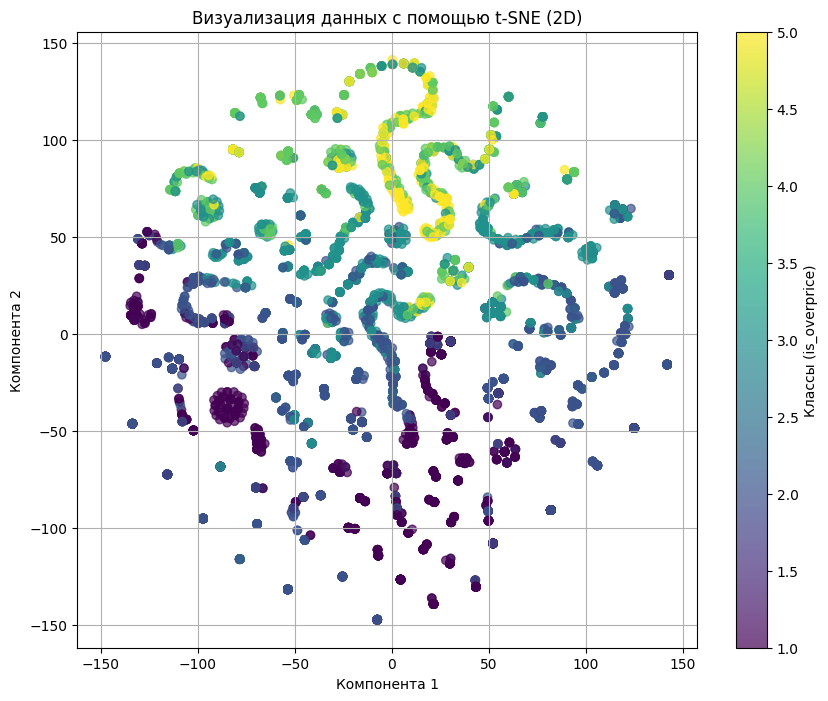

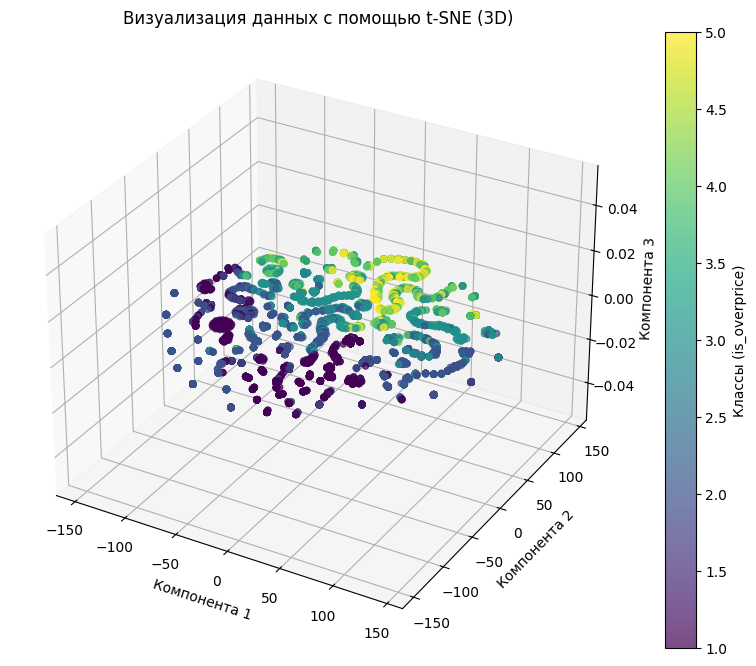

Точность классификации с t-SNE (2D): 0.7167
Точность классификации с t-SNE (3D): 0.7167


In [ ]:
from sklearn.manifold import TSNE

# Преобразование данных с помощью t-SNE
tsne_2d = TSNE(n_components=2, random_state=42)
X_tsne_2d = tsne_2d.fit_transform(X_classification.select_dtypes(include=['float64', 'int64']))

tsne_3d = TSNE(n_components=2, random_state=42)
X_tsne_3d = tsne_3d.fit_transform(X_classification.select_dtypes(include=['float64', 'int64']))

# 2D визуализация t-SNE
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_tsne_2d[:, 0], X_tsne_2d[:, 1], c=y_classification, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Классы (is_overprice)')
plt.title("Визуализация данных с помощью t-SNE (2D)")
plt.xlabel("Компонента 1")
plt.ylabel("Компонента 2")
plt.grid(True)
plt.show()

# 3D визуализация t-SNE
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_tsne_3d[:, 0], X_tsne_3d[:, 1], c=y_classification, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Классы (is_overprice)')
ax.set_title("Визуализация данных с помощью t-SNE (3D)")
ax.set_xlabel("Компонента 1")
ax.set_ylabel("Компонента 2")
ax.set_zlabel("Компонента 3")
plt.show()

# Классификация t-SNE (2D и 3D)
# Разделение данных
X_train_2d, X_test_2d, y_train, y_test = train_test_split(X_tsne_2d, y_classification, test_size=0.2, random_state=42)
X_train_3d, X_test_3d = train_test_split(X_tsne_3d, test_size=0.2, random_state=42)

# Модель
clf = RandomForestClassifier(random_state=42)

# Обучение на 2D данных
clf.fit(X_train_2d, y_train)
y_pred_2d = clf.predict(X_test_2d)
accuracy_2d = accuracy_score(y_test, y_pred_2d)
print(f"Точность классификации с t-SNE (2D): {accuracy_2d:.4f}")

# Обучение на 3D данных
clf.fit(X_train_3d, y_train)
y_pred_3d = clf.predict(X_test_3d)
accuracy_3d = accuracy_score(y_test, y_pred_3d)
print(f"Точность классификации с t-SNE (3D): {accuracy_3d:.4f}")


### А как видна идеальная картинка ? (БОНУС)

In [ ]:
from sklearn.datasets import load_digits

digest - датасет c "оттенками" серого визуализации чисел

In [ ]:
# Загрузка данных
digits = load_digits()
X, y = digits.data, digits.target

# Фильтрация: только числа 1-9
mask = y != 0
X = X[mask]
y = y[mask]

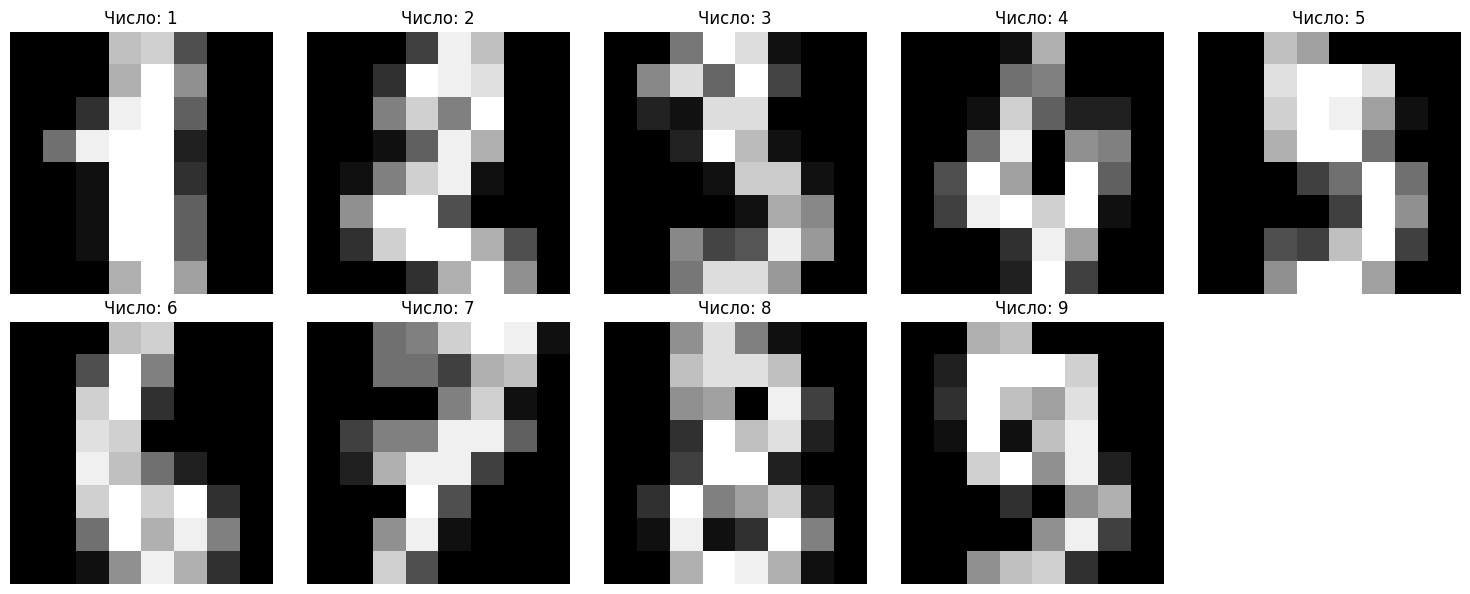

In [ ]:
# Визуализация всех цифр 1-9
plt.figure(figsize=(15, 6))

unique_labels = list(range(1, 10))
for i, label in enumerate(unique_labels):
    # Найдем первое вхождение каждой цифры
    idx = (y == label).argmax()
    plt.subplot(2, 5, i + 1)
    plt.imshow(X[idx].reshape(8, 8), cmap='gray', interpolation='nearest')
    plt.title(f"Число: {label}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
y

array([1, 2, 3, ..., 8, 9, 8])

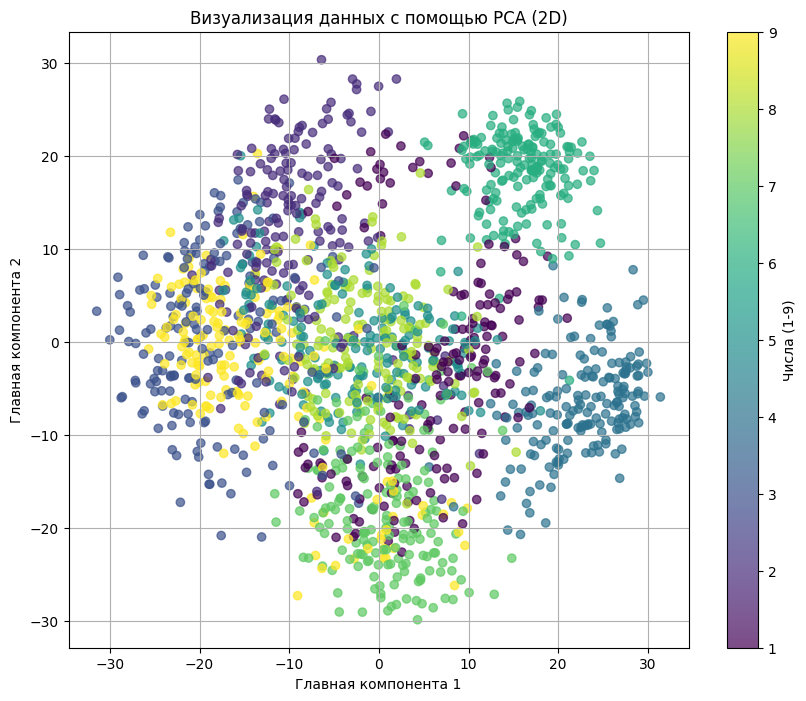

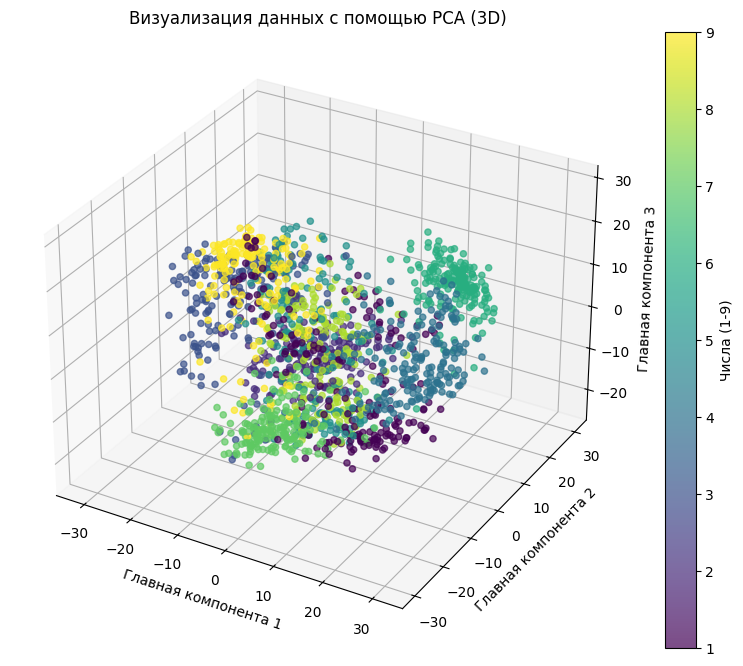

Точность классификации с PCA (2D): 0.5833
Точность классификации с PCA (3D): 0.7037


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# PCA: 2D
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=y, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Числа (1-9)')
plt.title("Визуализация данных с помощью PCA (2D)")
plt.xlabel("Главная компонента 1")
plt.ylabel("Главная компонента 2")
plt.grid(True)
plt.show()

# PCA: 3D
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2], c=y, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Числа (1-9)')
ax.set_title("Визуализация данных с помощью PCA (3D)")
ax.set_xlabel("Главная компонента 1")
ax.set_ylabel("Главная компонента 2")
ax.set_zlabel("Главная компонента 3")
plt.show()

# Классификация на основе PCA (2D)
X_train_2d, X_test_2d, y_train, y_test = train_test_split(X_pca_2d, y, test_size=0.2, random_state=42)
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_2d, y_train)
y_pred_2d = clf.predict(X_test_2d)
accuracy_pca_2d = accuracy_score(y_test, y_pred_2d)
print(f"Точность классификации с PCA (2D): {accuracy_pca_2d:.4f}")

# Классификация на основе PCA (3D)
X_train_3d, X_test_3d = train_test_split(X_pca_3d, test_size=0.2, random_state=42)
clf.fit(X_train_3d, y_train)
y_pred_3d = clf.predict(X_test_3d)
accuracy_pca_3d = accuracy_score(y_test, y_pred_3d)
print(f"Точность классификации с PCA (3D): {accuracy_pca_3d:.4f}")


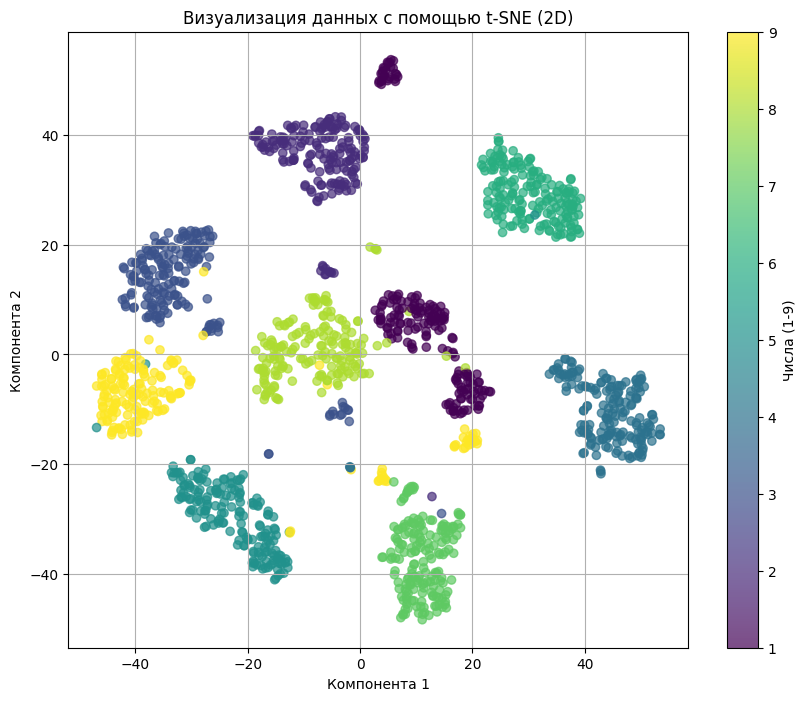

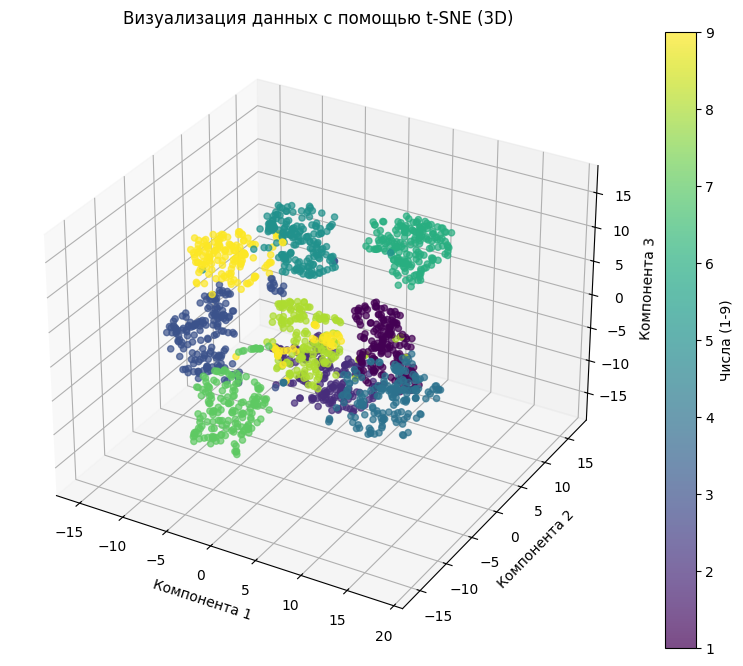

Точность классификации с t-SNE (2D): 0.9938
Точность классификации с t-SNE (3D): 0.9938


In [ ]:
from sklearn.manifold import TSNE

# t-SNE: 2D
tsne_2d = TSNE(n_components=2, random_state=42)
X_tsne_2d = tsne_2d.fit_transform(X)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_tsne_2d[:, 0], X_tsne_2d[:, 1], c=y, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Числа (1-9)')
plt.title("Визуализация данных с помощью t-SNE (2D)")
plt.xlabel("Компонента 1")
plt.ylabel("Компонента 2")
plt.grid(True)
plt.show()

# t-SNE: 3D
tsne_3d = TSNE(n_components=3, random_state=42)
X_tsne_3d = tsne_3d.fit_transform(X)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_tsne_3d[:, 0], X_tsne_3d[:, 1], X_tsne_3d[:, 2], c=y, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Числа (1-9)')
ax.set_title("Визуализация данных с помощью t-SNE (3D)")
ax.set_xlabel("Компонента 1")
ax.set_ylabel("Компонента 2")
ax.set_zlabel("Компонента 3")
plt.show()

# Классификация на основе t-SNE (2D)
X_train_tsne_2d, X_test_tsne_2d = train_test_split(X_tsne_2d, test_size=0.2, random_state=42)
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_tsne_2d, y_train)
y_pred_tsne_2d = clf.predict(X_test_tsne_2d)
accuracy_tsne_2d = accuracy_score(y_test, y_pred_tsne_2d)
print(f"Точность классификации с t-SNE (2D): {accuracy_tsne_2d:.4f}")

# Классификация на основе t-SNE (3D)
X_train_tsne_3d, X_test_tsne_3d = train_test_split(X_tsne_3d, test_size=0.2, random_state=42)
clf.fit(X_train_tsne_3d, y_train)
y_pred_tsne_3d = clf.predict(X_test_tsne_3d)
accuracy_tsne_3d = accuracy_score(y_test, y_pred_tsne_3d)
print(f"Точность классификации с t-SNE (3D): {accuracy_tsne_3d:.4f}")


### Поиск лучших параметров GridSearch и RandomSearch

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
import numpy as np

# Определение параметров для поиска
param_grid_regression = {
    'regressor__alpha': [0.1, 1.0, 10.0]  # Параметры регуляризации для Ridge
}

param_random_regression = {
    'regressor__alpha': np.linspace(0.1, 10, 100)  # Диапазон для случайного поиска
}

# Пайплайн для регрессии
regression_pipeline = Pipeline([
    ('preprocessor', preprocessor_regression),
    ('regressor', Ridge())
], verbose=True)

# GridSearchCV для регрессии
grid_search_reg = GridSearchCV(regression_pipeline, param_grid=param_grid_regression, cv=5, scoring='neg_mean_squared_error', verbose=1)
grid_search_reg.fit(X_train_reg, y_train_reg)
print("\nЛучшие параметры (GridSearch) для регрессии:", grid_search_reg.best_params_)
print("Лучший MSE (GridSearch):", -grid_search_reg.best_score_)

# RandomizedSearchCV для регрессии
random_search_reg = RandomizedSearchCV(regression_pipeline, param_distributions=param_random_regression, n_iter=10, cv=5, scoring='neg_mean_squared_error', verbose=1, random_state=42)
random_search_reg.fit(X_train_reg, y_train_reg)
print("\nЛучшие параметры (RandomSearch) для регрессии:", random_search_reg.best_params_)
print("Лучший MSE (RandomSearch):", -random_search_reg.best_score_)


Fitting 5 folds for each of 3 candidates, totalling 15 fits
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   0.0s
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   0.0s
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   0.0s
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransforme

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline

# Определение параметров для поиска
param_grid_classification = {
    'classifier__max_depth': [5, 10, 15],
    'classifier__min_samples_split': [2, 5, 10]
}

param_random_classification = {
    'classifier__max_depth': np.arange(1, 20),
    'classifier__min_samples_split': np.arange(2, 20)
}

# Пайплайн для классификации
classification_pipeline = Pipeline([
    ('preprocessor', preprocessor_classification),
    ('classifier', DecisionTreeClassifier(random_state=42))
], verbose=True)

# GridSearchCV для классификации
grid_search_clf = GridSearchCV(classification_pipeline, param_grid=param_grid_classification, cv=5, scoring='accuracy', verbose=1)
grid_search_clf.fit(X_train_clf, y_train_clf)
print("\nЛучшие параметры (GridSearch) для классификации:", grid_search_clf.best_params_)
print("Лучшая точность (GridSearch):", grid_search_clf.best_score_)

# RandomizedSearchCV для классификации
random_search_clf = RandomizedSearchCV(classification_pipeline, param_distributions=param_random_classification, n_iter=10, cv=5, scoring='accuracy', verbose=1, random_state=42)
random_search_clf.fit(X_train_clf, y_train_clf)
print("\nЛучшие параметры (RandomSearch) для классификации:", random_search_clf.best_params_)
print("Лучшая точность (RandomSearch):", random_search_clf.best_score_)


Fitting 5 folds for each of 9 candidates, totalling 45 fits
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.0s
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.0s
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.0s
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransforme

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score

df = pd.read_csv('diamond.csv')

df['is_overprice'] = np.where(df['Price'] >= 10000, 1, 0)
df.is_overprice = df.is_overprice.astype('category')
df.Color = df.Color.astype('category')
df.Clarity = df.Clarity.astype('category')
df.Polish = df.Polish.astype('category')
df.Symmetry = df.Symmetry.astype('category')
df.Report = df.Report.astype('category')
df.Cut = df.Report.astype('category')

y = df['is_overprice'] # выбираем целевую переменную (категориальную)
X = df.drop('is_overprice', axis=1) # переменные для проверки влияния

# В моем случае я дропаю базовую переменную, а не только. Y
X = X.drop('Price', axis=1)
df.drop('Price', axis=1).info()

# Разделение признаков на числовые и категориальные
numeric_features = X.select_dtypes(include=['float64', 'int64']).columns
categorical_features = X.select_dtypes(include=['category']).columns

# Разделение данных на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Преобразование числовых данных
scaler = StandardScaler()
X_train_numeric = scaler.fit_transform(X_train[numeric_features])
X_test_numeric = scaler.transform(X_test[numeric_features])

# Преобразование категориальных данных
encoder = OneHotEncoder()
X_train_categorical = encoder.fit_transform(X_train[categorical_features]).toarray()
X_test_categorical = encoder.transform(X_test[categorical_features]).toarray()

# Объединение преобразованных данных
import numpy as np
X_train_transformed = np.hstack([X_train_numeric, X_train_categorical])
X_test_transformed = np.hstack([X_test_numeric, X_test_categorical])

# Определение параметров для RandomizedSearchCV
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Обучение RandomForestClassifier с RandomizedSearchCV
rf = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    scoring='accuracy',
    random_state=42,
    verbose=1
)

random_search.fit(X_train_transformed, y_train)

# Лучшие параметры и точность
best_params = random_search.best_params_
best_score = random_search.best_score_

# Тестирование на отложенной выборке
y_pred = random_search.best_estimator_.predict(X_test_transformed)
test_accuracy = accuracy_score(y_test, y_pred)

print("\nЛучшие параметры:", best_params)
print(f"Лучшая точность на кросс-валидации: {best_score:.4f}")
print(f"Точность на тестовой выборке: {test_accuracy:.4f}")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Carat Weight  6000 non-null   float64 
 1   Cut           6000 non-null   category
 2   Color         6000 non-null   category
 3   Clarity       6000 non-null   category
 4   Polish        6000 non-null   category
 5   Symmetry      6000 non-null   category
 6   Report        6000 non-null   category
 7   is_overprice  6000 non-null   category
dtypes: category(7), float64(1)
memory usage: 89.3 KB
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Лучшие параметры: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 20, 'bootstrap': True}
Лучшая точность на кросс-валидации: 0.9642
Точность на тестовой выборке: 0.9658
